# **Thư viện**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

# **Dữ liệu**

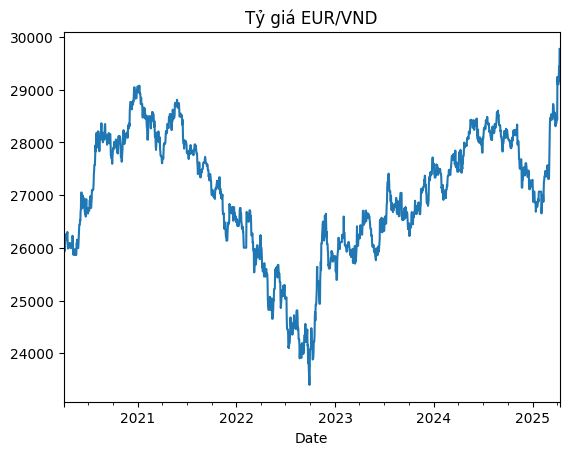

In [81]:
df = pd.read_csv(r"D:\eur-vnd-exchange-rate\data\processed\EUR_VND_Exchange_Rate.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

y = df['Sell']
y.plot(title="Tỷ giá EUR/VND")
plt.show()

In [82]:
df.tail(2)

,Sell
Date,
2025-04-10,29178.76
2025-04-11,29775.69


<Figure size 1400x1000 with 0 Axes>

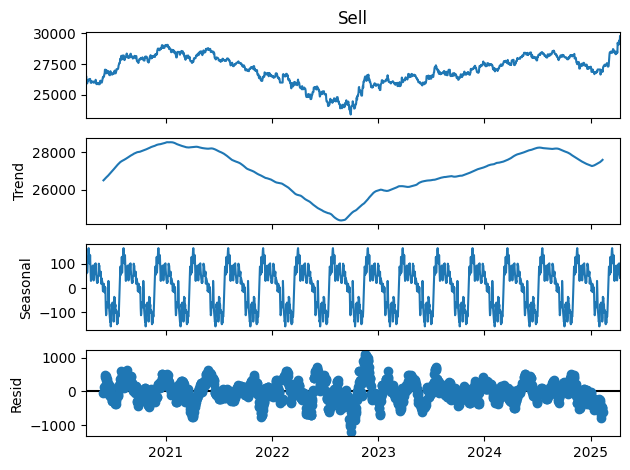

In [83]:
# Phân tích thành phần của chuỗi thời gian
decomposition = seasonal_decompose(df['Sell'], model='additive', period=120)
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

# **Kiểm tra tính dừng (ADF Test)**

In [84]:
result = adfuller(y)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Chuỗi dừng")
else:
    print("Chuỗi không dừng, cần lấy sai phân")


ADF Statistic: -1.2253450973203506
p-value: 0.6625989844374176
Chuỗi không dừng, cần lấy sai phân


## **Lấy sai phân**

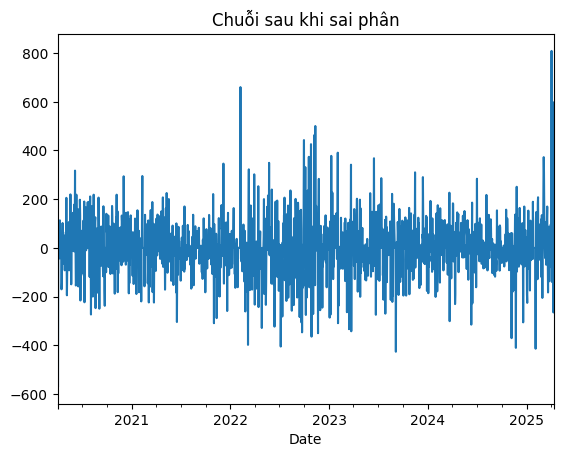

In [85]:
y_diff = y.diff().dropna()
y_diff.plot(title="Chuỗi sau khi sai phân")
plt.show()

In [86]:
result = adfuller(y_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Chuỗi dừng")
else:
    print("Chuỗi không dừng, cần lấy sai phân")

ADF Statistic: -42.30414205661223
p-value: 0.0
Chuỗi dừng


=> d = 1

# **ACF và PACF để chọn p, q**

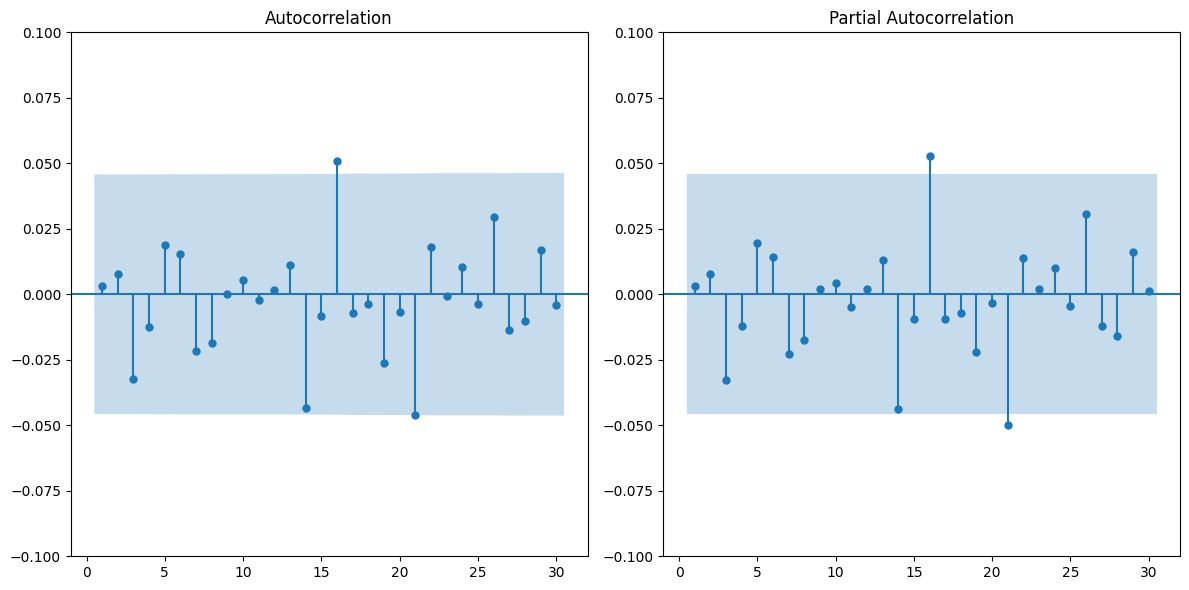

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

_ = plot_acf(y_diff, ax=ax1, lags=30, zero=False)
_ = plot_pacf(y_diff, ax=ax2, lags=30, zero=False)

ax1.set_ylim(-0.1, 0.1)
ax2.set_ylim(-0.1, 0.1)

plt.tight_layout()
plt.show()


ACF loại bỏ lag0 tất cả đều trong vùng xanh 
=> q = 0  

Tương tự, các giá trị PACF đều nằm trong vùng xanh, tức là không có độ trễ nào nổi bật rõ ràng
=> p = 0

(p, d, q) = (0, 1, 0)

# **ARIMA**

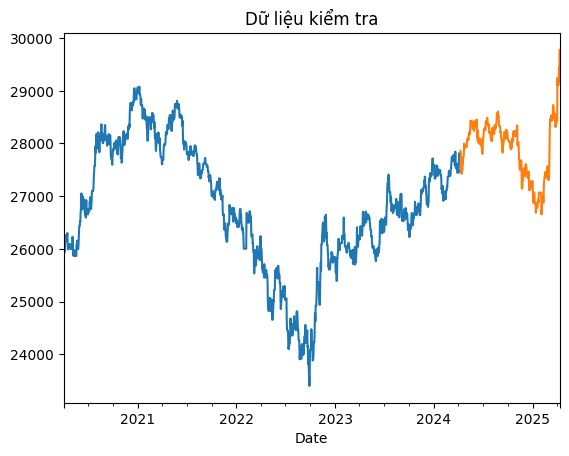

In [88]:
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

train.plot(title="Dữ liệu huấn luyện")
test.plot(title="Dữ liệu kiểm tra")
plt.show()

In [89]:
# Fit mô hình ARIMA(0, 1, 0) trên tập huấn luyện
model = ARIMA(train, order=(0, 1, 0))
result = model.fit()

model_path = r"D:\eur-vnd-exchange-rate\models\ARIMA\arima.pkl"
joblib.dump(model, model_path)

print(result.summary())


                               SARIMAX Results                                
Dep. Variable:                   Sell   No. Observations:                 1469
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -8933.647
Date:                Mon, 14 Apr 2025   AIC                          17869.294
Time:                        20:44:18   BIC                          17874.586
Sample:                    04-01-2020   HQIC                         17871.267
                         - 04-08-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.13e+04    245.129     46.101      0.000    1.08e+04    1.18e+04
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               876.21
Prob(Q):                              0.92   Pr

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


# **Đánh giá mô hình**

Đánh giá mô hình ARIMA
MAE: 483.0182
MSE: 311449.3420
RMSE: 558.0765
MAPE: 1.7302%


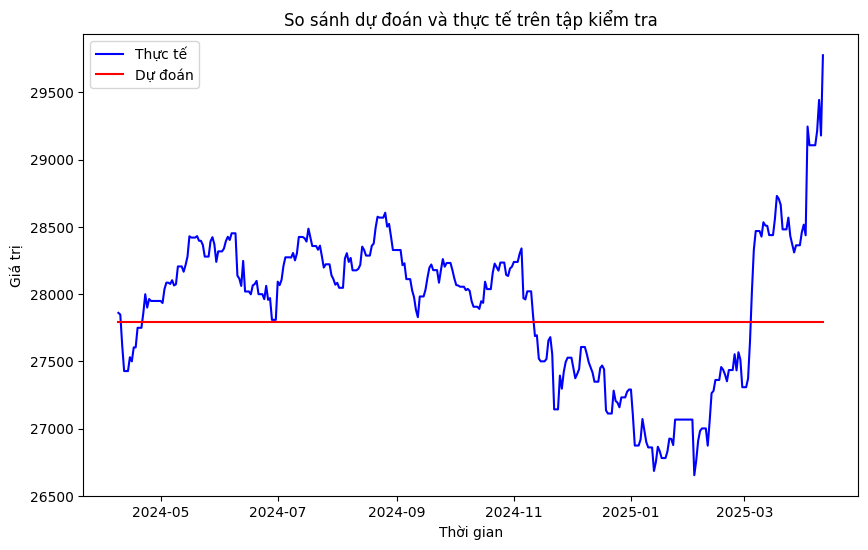

In [91]:
# Dự báo trên tập kiểm tra (test)
y_pred = result.forecast(steps=len(test))

# Đánh giá mô hình
mae = mean_absolute_error(test, y_pred)
mse = mean_squared_error(test, y_pred)
rmse = np.sqrt(MSE)
mape = np.mean(np.abs((test - y_pred) / test)) * 100

print("Đánh giá mô hình ARIMA")

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")

# Vẽ biểu đồ so sánh thực tế và dự báo
plt.figure(figsize=(10, 6))
plt.plot(test, label='Thực tế', color='blue')
plt.plot(y_pred, label='Dự đoán', color='red')
plt.title('So sánh dự đoán và thực tế trên tập kiểm tra')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.legend()
plt.show()
